In [1]:
from utils import *

C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
GAME = 'Pong-ram-v0'
env = gym.make(GAME)
S, A = env.observation_space.shape[0], env.action_space.n
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Box(128,)
Discrete(6)
(-inf, inf)


In [3]:
class Model(tf.keras.Model):
    def __init__(self, S, A):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(50, 'relu')
        self.W2 = tf.keras.layers.Dense(50, 'relu')
        self.V = tf.keras.layers.Dense(1)
        self.P = tf.keras.layers.Dense(A, 'softmax')
        self.build((None,S))
    
    def call(self, x):
        x = self.W1(x)
        x = self.W2(x)
        return self.P(x), self.V(x)
    
create_nn = lambda S,A: Model(S,A)

In [17]:
_min, clip, log = tf.minimum, tf.clip_by_value, tf.math.log
class Agent():
    def __init__(self, num_states, num_actions, lr, gamma=0.99, ppo_fn=ppo1):
        self.S, self.A = num_states, num_actions
        self.optimizer = tf.optimizers.Adam(lr)
        self.y = gamma
        self.nn = create_nn(S,A)
        self.D = deque(maxlen=20000) # save all transitions
        self.batch_size = 128
        self.ppo_fn = ppo_fn
        
    def first_step(self, s, sdict): # [1,S]
        pi, v = self.nn(s) # [1,A], []
        a = tf.random.categorical(tf.math.log(pi), num_samples=1) # [1,1]
        a = int(a[0,0]) # []
        self.E = []
        self.s, self.a, self.pi = s, a, pi # save prev state + action
        return a
        
    def step(self, r, s, sdict): # [], [1,S]
        # append tuple to experience replay
        self.E.append([self.s, self.a, self.pi, r, s]) # s, a, pi, r, s'
        pi, v = self.nn(s) # [1,A], []
        a = tf.random.categorical(tf.math.log(pi), num_samples=1) # [1,1]
        a = int(a[0,0]) # []
        self.s, self.a, self.pi = s, a, pi # save previous state, action
        return a
    
    def last_step(self, r, sdict):
        self.E.append([self.s, self.a, self.pi, r, None]) # s, a, pi, r, s'
        # prerprocess reward
        R = np_map(lambda x: x[3], self.E) # [e]
        G = discount_rewards(R, self.y, normalize=True)[:,None] # [e,1]
        for i,_ in enumerate(self.E): self.E[i][3] = G[i]
        # extend D (data) w/ E (episode data)
        self.D.extend(self.E)
        if len(self.D) < self.batch_size: return
        B = random.sample(self.D, self.batch_size)
        # need squeeze, because self.s/a is [1,S/A], so S=[e,1,S/A] -> [e,S/A]
        S = np.squeeze(np_map(lambda x: x[0], B)) # [e,S], where e - number steps in episode
        if S.ndim == 1: S = S[None,:] # for cases if example size is 1 and squeezed
        A = np.squeeze(np_map(lambda x: x[1], B)) # [e]
        A = one_hot(A.astype(int), C=self.A) # [e,A]
        A_old = np.squeeze(np_map(lambda x: x[2], B)) # [e,A]
        A_old = tf.clip_by_value(A_old, 1e-6, 1-1e-6) # [e,A]
        G = np.squeeze(np_map(lambda x: x[3], B))[:,None] # [e,1]
        # train nn for 1 epoch
        with tf.GradientTape() as tape:
            A_hat, V_hat = self.nn(S) # [e,A], [e,1]
            A_hat = tf.clip_by_value(A_hat, 1e-6, 1-1e-6) # clip tf.log(0)
            Adv = tf.stop_gradient(G - V_hat) # [e,A] (advantage)
            policy_loss = self.ppo_fn(A_hat, A_old, Adv, A)
            entropy = A_hat * tf.math.log(A_hat)
            value_loss = (G - V_hat)**2 # [e,A]
            each_loss = policy_loss - 0.001*entropy + 0.5*value_loss # [e,A]
            loss = tf.reduce_mean(tf.reduce_sum(each_loss, axis=-1)) # avg of all examples
        # calc + update gradients
        nn_vars = self.nn.trainable_variables
        grads = tape.gradient(loss, nn_vars)
        self.optimizer.apply_gradients(zip(grads, nn_vars))

In [18]:
def ppo1(A_new, A_old, Adv, A, e=0.2): # [b,A], [b,1], [b,A], []
    # ratio=pi/pi_old, Advantage=G-V, Action that was taken (one-hot), epsilon
    r = A_new/A_old # = tf.exp( log(A_hat) - log(A_old) ) # [e,A]
    return - A * _min( r*Adv, clip(r,1-e,1+e)*Adv )

In [19]:
def ppo2(A_new, A_old, Adv, A, e=0.2): # [b,A], [b,1], [b,A], []
    # ratio=pi/pi_old, Advantage=G-V, Action that was taken (one-hot), epsilon
    r = A_new/A_old # = tf.exp( log(A_hat) - log(A_old) ) # [e,A]
    return - A * _min( r*Adv, tf.where(Adv>0, (1+e)*Adv, (1-e)*Adv) )

In [22]:
agent_fn = lambda S,A,ppo_fn: Agent(S, A, ppo_fn=ppo_fn, lr=1e-4, gamma=0.99)

In [ ]:
exp = Experiment(env, agent_fn(S,A,ppo1))
exp.agent_state_preprocessing_fn = lambda s: np.expand_dims(s, 0) / 256
df = exp.run(1000,1)
plot_df(df)

In [160]:
exp.show_play()

101

In [55]:
agent_fn = lambda S,A,env_fn=None: Agent(S, A, ppo_fn=ppo1, lr=1e-2, gamma=0.99)
test_agent_on_simple_games(agent_fn, 'PPO', game_dict={'CartPole-v1':500})

True

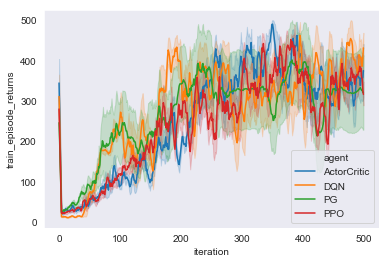

In [133]:
df = load_my_benchmark('CartPole-v1')
plot_df(df, rolling_mean=5)